# Air Quality Prediction

### Importing the packages

In [2]:
pip install pyreadr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 6.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import pyreadr
import glob
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    classification_report,
)
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


### Loading the dataset

In [4]:
from urllib.request import urlretrieve
from urllib.error import HTTPError


def importAURN(site, years):
    site = site.upper()

    # If a single year is passed then convert to a list with a single value
    if type(years) is int:
        years = [years]

    downloaded_data = []
    df = pd.DataFrame()
    errors_raised = False

    for year in years:
        # Generate correct URL and download to a temporary file
        url = f"https://uk-air.defra.gov.uk/openair/R_data/{site}_{year}.RData"

        try:
            filename, headers = urlretrieve(url)

            result = pyreadr.read_r(filename)

            # done! let's see what we got
#             print(result.keys()) # let's check what objects we got

            df1 = result[f"{site}_{year}"] # extract the pandas data frame for object df1

            df = pd.concat([df,df1], axis=0)

        except HTTPError:
            errors_raised = True
            continue
#     df.set_index('date')
    return df


def importMeta():
    url = "http://uk-air.defra.gov.uk/openair/R_data/AURN_metadata.RData"

    filename, headers = urlretrieve(url)

    result = pyreadr.read_r(filename)

    meta = result['AURN_metadata']

    meta = meta.drop_duplicates(subset=['site_id'])

    return meta

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
##import AURN (site code, year (single value or list))
df = importAURN("LEAR", [2018,2019,2020,2021,2022])
## Import meta data about all AURN stations operating in the UK.
meta = importMeta()

In [6]:
df

,date,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2.5,NV2.5,V2.5,wd,ws,temp,AT10,AP10,AT2.5,AP2.5,site,code
0,2018-01-01 00:00:00,0.85900,4.07140,5.38851,11.000,8.2,2.8,6.100,4.1,2.0,250.9,6.7,3.7,5.4,972.0,5.3,971.0,Leamington Spa Rugby Road,LEAR
1,2018-01-01 01:00:00,0.52494,4.14072,4.94562,12.100,7.9,4.2,6.500,4.5,2.0,247.1,7.1,3.6,5.7,972.0,5.7,972.0,Leamington Spa Rugby Road,LEAR
2,2018-01-01 02:00:00,0.39371,3.21626,3.81994,11.700,8.7,3.0,5.200,3.0,2.2,241.4,7.4,3.6,5.8,972.0,5.4,971.0,Leamington Spa Rugby Road,LEAR
3,2018-01-01 03:00:00,0.35792,2.77289,3.32169,8.700,6.2,2.5,6.400,2.1,4.3,242.5,8.2,3.9,5.3,972.0,5.3,971.0,Leamington Spa Rugby Road,LEAR
4,2018-01-01 04:00:00,0.32212,2.27416,2.76807,6.900,4.9,2.0,7.200,3.5,3.7,243.2,8.5,4.0,5.8,972.0,5.7,971.0,Leamington Spa Rugby Road,LEAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,0.89275,9.01942,10.38827,3.900,NaN,NaN,2.642,NaN,NaN,227.9,10.1,11.5,NaN,NaN,NaN,NaN,Leamington Spa Rugby Road,LEAR
8756,2022-12-31 20:00:00,0.75540,5.83685,6.99512,2.750,NaN,NaN,2.193,NaN,NaN,230.0,11.7,11.1,NaN,NaN,NaN,NaN,Leamington Spa Rugby Road,LEAR
8757,2022-12-31 21:00:00,0.48071,4.11774,4.85482,3.150,NaN,NaN,2.429,NaN,NaN,236.1,12.0,10.2,NaN,NaN,NaN,NaN,Leamington Spa Rugby Road,LEAR
8758,2022-12-31 22:00:00,0.44637,3.59617,4.28059,3.525,NaN,NaN,2.288,NaN,NaN,230.5,10.7,9.3,NaN,NaN,NaN,NaN,Leamington Spa Rugby Road,LEAR


In [7]:
### create the copy for later use
df_copy = df.copy()
#df = pd.read_csv('station_day.csv')
#df

### Data Analysis and Preprocessing

In [8]:
print("The dataset contains {} rows and {} columns".format(df.shape[0],df.shape[1]))

The dataset contains 43824 rows and 19 columns


In [9]:
# check some basic stats of dataset
df.describe()

,NO,NO2,NOXasNO2,PM10,NV10,V10,PM2.5,NV2.5,V2.5,wd,ws,temp,AT10,AP10,AT2.5,AP2.5
count,40943.000000,40943.000000,40943.000000,40057.000000,9043.000000,8901.000000,40755.000000,9741.000000,9599.000000,42672.000000,42672.000000,42672.000000,12508.000000,11393.000000,12509.000000,11572.000000
mean,5.162129,14.161482,22.076635,11.907943,11.588278,3.497371,8.202971,8.320172,3.861392,198.209538,4.557035,9.117009,9.396650,990.854823,9.463051,993.494781
std,12.629105,12.017373,28.400290,8.437087,8.743211,3.055912,7.274535,7.507562,3.038523,91.472663,2.500686,5.759551,6.517645,11.477758,6.570361,12.068393
min,-0.047240,0.030350,0.403500,-2.100000,-3.300000,-4.300000,-3.900000,-3.800000,-5.000000,0.000000,0.000000,-7.100000,-8.400000,958.000000,-8.600000,958.000000
25%,0.890890,5.890400,7.895230,6.450000,5.900000,1.500000,3.703000,3.800000,2.000000,129.500000,2.700000,5.000000,5.000000,983.000000,5.000000,986.000000
50%,1.905030,10.440730,13.764460,9.700000,9.700000,2.800000,5.991000,6.300000,3.300000,219.400000,4.100000,8.900000,8.400000,992.000000,8.500000,995.000000
75%,4.288505,18.644800,24.875995,14.800000,14.850000,4.700000,10.118000,10.300000,5.100000,260.300000,6.000000,13.100000,13.400000,999.000000,13.500000,1002.000000
max,388.117180,142.504200,651.527180,117.050000,80.400000,28.200000,104.010000,68.200000,30.300000,360.000000,20.100000,30.300000,33.200000,1021.000000,33.000000,1025.000000


In [10]:
# check for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      43824 non-null  datetime64[ns]
 1   NO        40943 non-null  float64       
 2   NO2       40943 non-null  float64       
 3   NOXasNO2  40943 non-null  float64       
 4   PM10      40057 non-null  float64       
 5   NV10      9043 non-null   float64       
 6   V10       8901 non-null   float64       
 7   PM2.5     40755 non-null  float64       
 8   NV2.5     9741 non-null   float64       
 9   V2.5      9599 non-null   float64       
 10  wd        42672 non-null  float64       
 11  ws        42672 non-null  float64       
 12  temp      42672 non-null  float64       
 13  AT10      12508 non-null  float64       
 14  AP10      11393 non-null  float64       
 15  AT2.5     12509 non-null  float64       
 16  AP2.5     11572 non-null  float64       
 17  site      438

In [11]:
### check for the missing values
df.isna().sum()

date            0
NO           2881
NO2          2881
NOXasNO2     2881
PM10         3767
NV10        34781
V10         34923
PM2.5        3069
NV2.5       34083
V2.5        34225
wd           1152
ws           1152
temp         1152
AT10        31316
AP10        32431
AT2.5       31315
AP2.5       32252
site            0
code            0
dtype: int64

#### Observations:
- The dataset has alot of missing values.
- We are going to handle the missing values by their median

In [12]:
# seperating the categorical featues from numeric features
numeric_cols = df.select_dtypes(['float64','int64']).columns
categoric_cols = df.select_dtypes('object').columns

df_numeric = df[numeric_cols]
df_categoric = df[categoric_cols]

In [13]:
## handling the missing value of numeric features
for i in df_numeric.columns:
    df_numeric[i] = df_numeric[i].fillna(df_numeric[i].median())

In [14]:
# concatinating both data frames
df = pd.concat([df_numeric,df_categoric],axis=1)

In [15]:
### again check for the missing values
df.isna().sum()

NO          0
NO2         0
NOXasNO2    0
PM10        0
NV10        0
V10         0
PM2.5       0
NV2.5       0
V2.5        0
wd          0
ws          0
temp        0
AT10        0
AP10        0
AT2.5       0
AP2.5       0
site        0
dtype: int64

In [16]:
df['label'] = np.where(df['NO2'] >= 40, 1, 0)
df = df.drop("NO2",axis=1)

#### Univariate Analysis

In [17]:
#
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    print(data[feature].value_counts())
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(25, 20))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

0    41973
1     1851
Name: label, dtype: int64


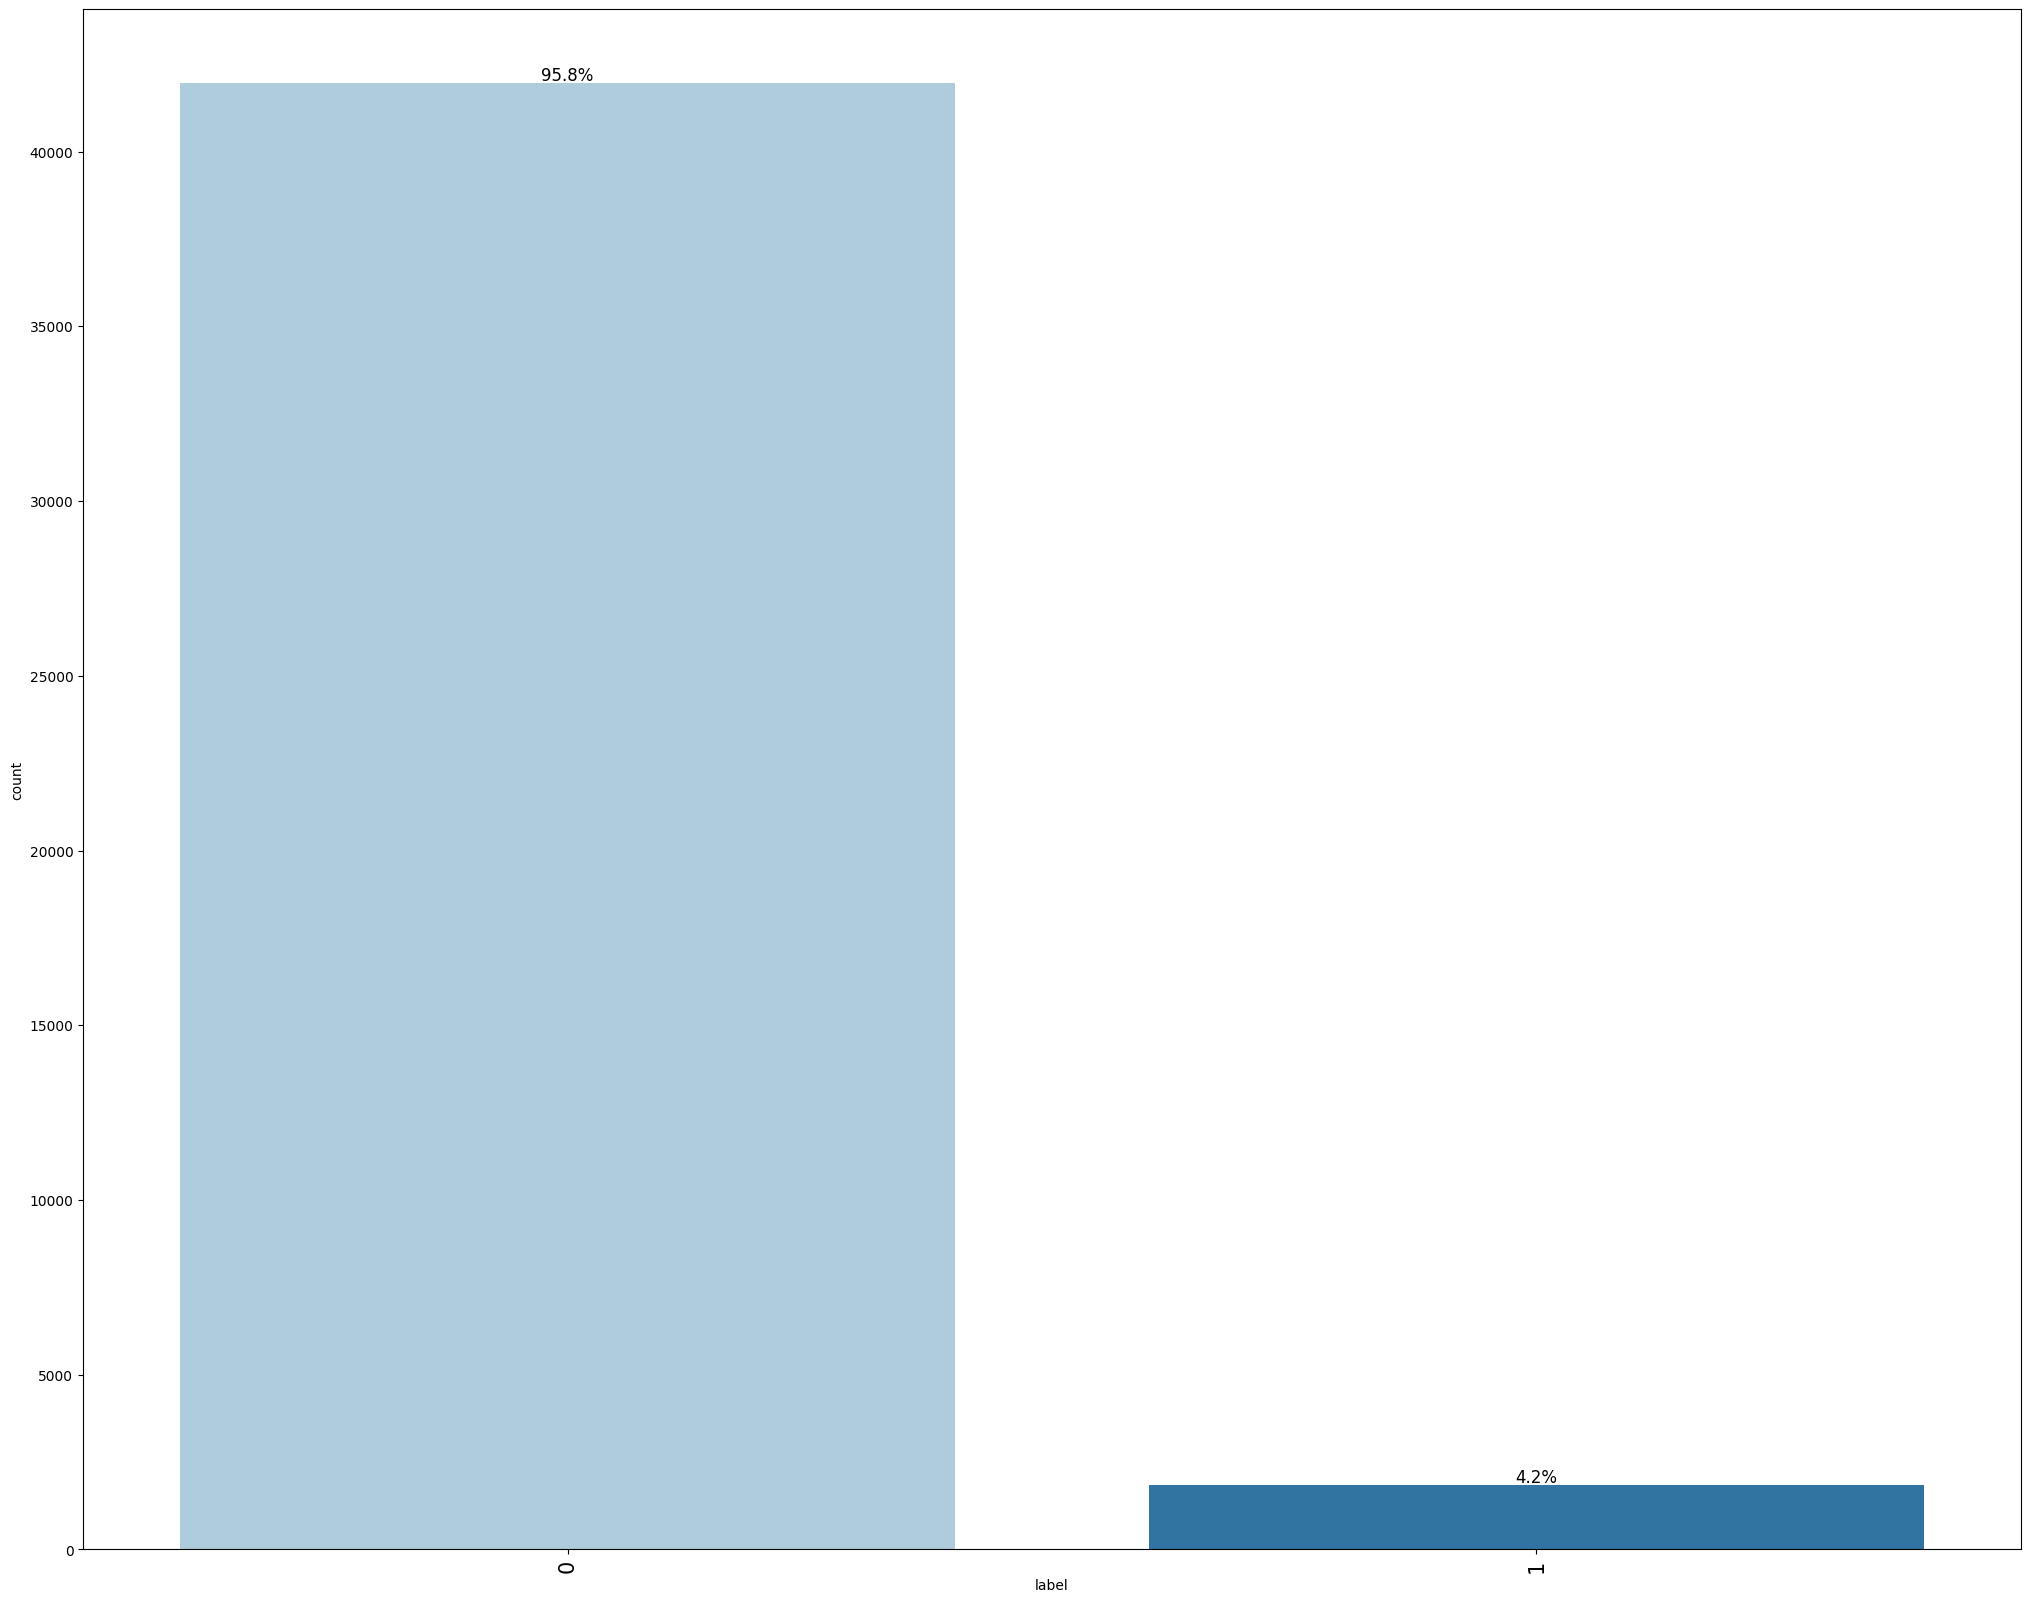

In [18]:
### Check the class distribution
labeled_barplot(df, 'label', perc=True)

#### Observations:
- The dataset is imbalanced

In [19]:
### DROp the fetures that we are not going to use
df = df.drop(['site','NOXasNO2'],axis=1)

In [20]:
df

,NO,PM10,NV10,V10,PM2.5,NV2.5,V2.5,wd,ws,temp,AT10,AP10,AT2.5,AP2.5,label
0,0.85900,11.000,8.2,2.8,6.100,4.1,2.0,250.9,6.7,3.7,5.4,972.0,5.3,971.0,0
1,0.52494,12.100,7.9,4.2,6.500,4.5,2.0,247.1,7.1,3.6,5.7,972.0,5.7,972.0,0
2,0.39371,11.700,8.7,3.0,5.200,3.0,2.2,241.4,7.4,3.6,5.8,972.0,5.4,971.0,0
3,0.35792,8.700,6.2,2.5,6.400,2.1,4.3,242.5,8.2,3.9,5.3,972.0,5.3,971.0,0
4,0.32212,6.900,4.9,2.0,7.200,3.5,3.7,243.2,8.5,4.0,5.8,972.0,5.7,971.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.89275,3.900,9.7,2.8,2.642,6.3,3.3,227.9,10.1,11.5,8.4,992.0,8.5,995.0,0
8756,0.75540,2.750,9.7,2.8,2.193,6.3,3.3,230.0,11.7,11.1,8.4,992.0,8.5,995.0,0
8757,0.48071,3.150,9.7,2.8,2.429,6.3,3.3,236.1,12.0,10.2,8.4,992.0,8.5,995.0,0
8758,0.44637,3.525,9.7,2.8,2.288,6.3,3.3,230.5,10.7,9.3,8.4,992.0,8.5,995.0,0


In [21]:
### Check the features correlation:

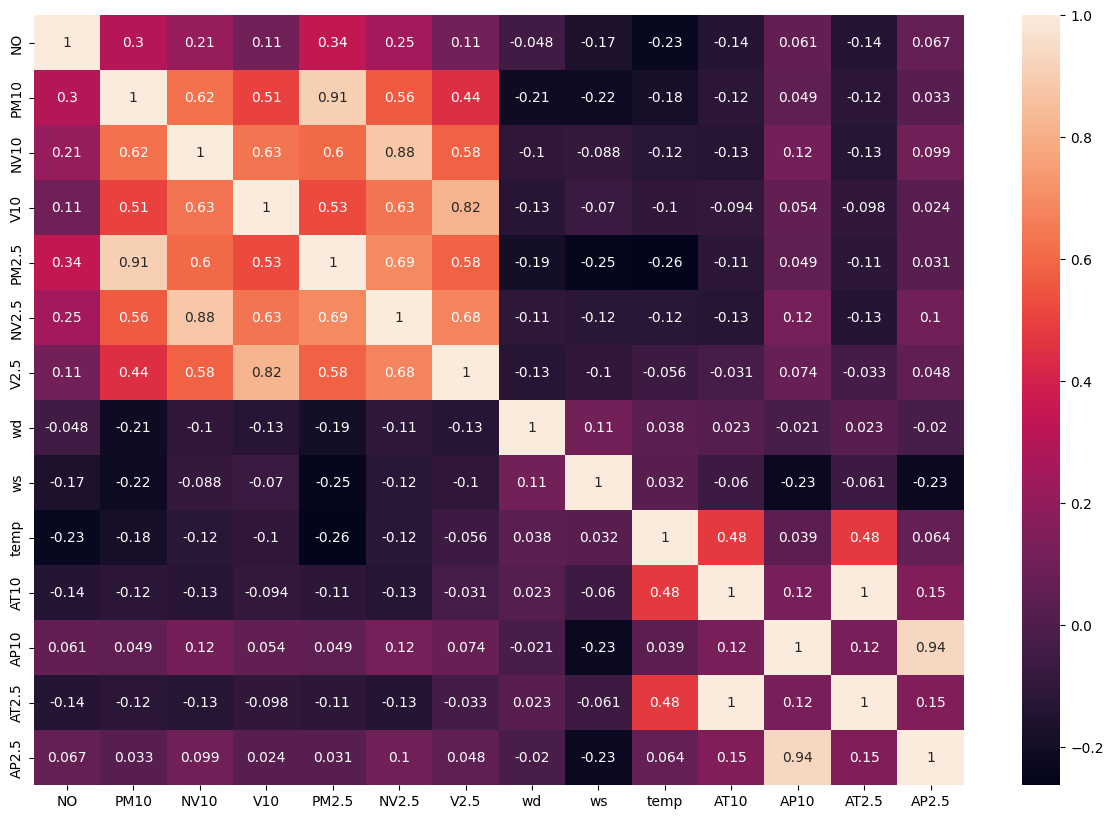

In [22]:
plt.figure(figsize=(15,10))
sns.heatmap(df.iloc[:,:-1].corr(),annot=True)
plt.show()

In [23]:
# seperate class labels and features
X= df.drop("label",axis=1)
y=df["label"]

In [24]:
### Scaling the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3
)



In [26]:
#X_train,y_train = RandomOverSampler(random_state=42)

### MACHINE LEARNING MODELS

In [27]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target,classes):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)



    #y_pred = model.predict(predictors)
    cm = confusion_matrix(target, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes )
    disp.plot(xticks_rotation = "vertical")
    plt.show()
    #labels = np.asarray(
    #    [
    #        ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
    #        for item in cm.flatten()
    #    ]
    #).reshape(2, 2)

    #plt.figure(figsize=(6, 4))
    #plt.show()
    #sns.heatmap(cm, annot=labels, fmt="")
    #plt.ylabel("True label")
    #plt.xlabel("Predicted label")
    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="macro")  # to compute Recall
    precision = precision_score(target, pred,average="macro")  # to compute Precision
    f1 = f1_score(target, pred,average="macro")# to compute F1-score
    print(classification_report(target, pred))

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1},
        index=[0],
    )

    return df_perf

### KNN Model

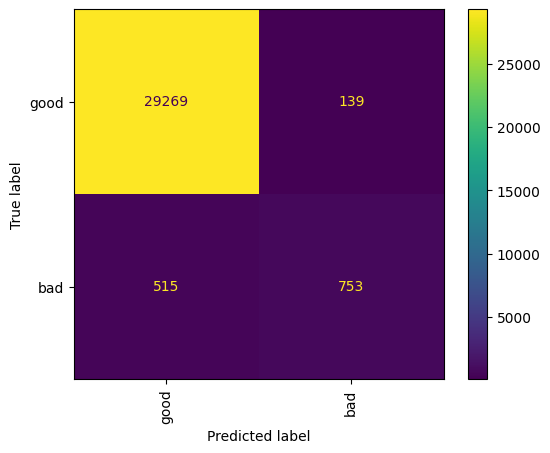

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29408
           1       0.84      0.59      0.70      1268

    accuracy                           0.98     30676
   macro avg       0.91      0.79      0.84     30676
weighted avg       0.98      0.98      0.98     30676



,Accuracy,Recall,Precision,F1
0,0.97868,0.794561,0.91344,0.843087


In [28]:
### Initialize the model
model1 = KNeighborsClassifier(n_neighbors=5)

# train the model
model1.fit(X_train,y_train)

# check performance on train data
knn_train_perf = model_performance_classification_sklearn(
    model1, X_train, y_train
,classes= ["good","bad"])
knn_train_perf


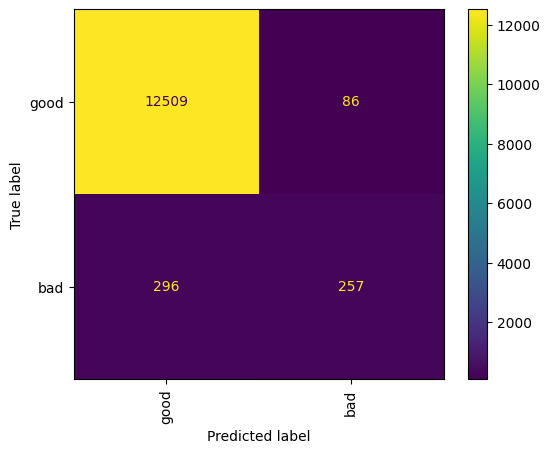

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12595
           1       0.75      0.46      0.57       553

    accuracy                           0.97     13148
   macro avg       0.86      0.73      0.78     13148
weighted avg       0.97      0.97      0.97     13148



,Accuracy,Recall,Precision,F1
0,0.970946,0.728955,0.863078,0.779311


In [ ]:
# check performance on test data
knn_test_perf = model_performance_classification_sklearn(
    model1, X_test, y_test,classes=["good","bad"]
)
knn_test_perf

### AdaBoost Classifier

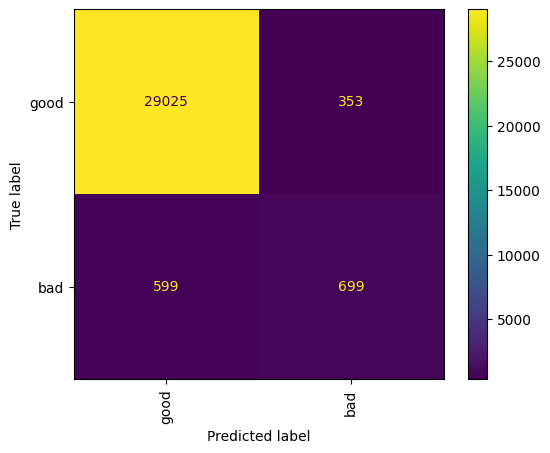

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     29378
           1       0.66      0.54      0.59      1298

    accuracy                           0.97     30676
   macro avg       0.82      0.76      0.79     30676
weighted avg       0.97      0.97      0.97     30676



,Accuracy,Recall,Precision,F1
0,0.968966,0.763253,0.822114,0.789379


In [ ]:
### Initialize the model
model2 = AdaBoostClassifier(random_state=42)

# train the model
model2.fit(X_train,y_train)

# check performance on train data
adb_train_perf = model_performance_classification_sklearn(model2, X_train, y_train,classes=["good","bad"])
adb_train_perf

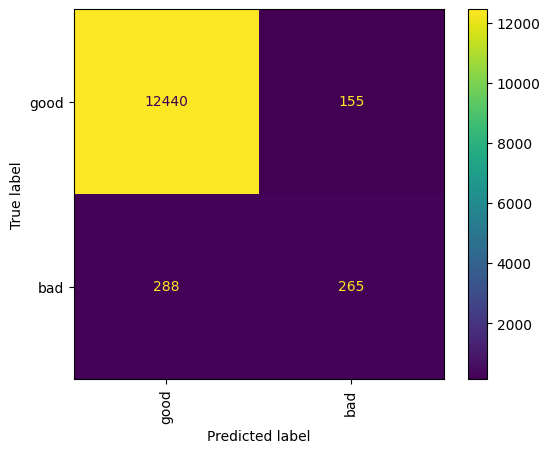

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12595
           1       0.63      0.48      0.54       553

    accuracy                           0.97     13148
   macro avg       0.80      0.73      0.76     13148
weighted avg       0.96      0.97      0.96     13148



,Accuracy,Recall,Precision,F1
0,0.966307,0.733449,0.804163,0.763607


In [ ]:
# check performance on train data
adb_test_perf = model_performance_classification_sklearn(
    model2, X_test, y_test,classes=["good","bad"]
)
adb_test_perf

### Decision Tree


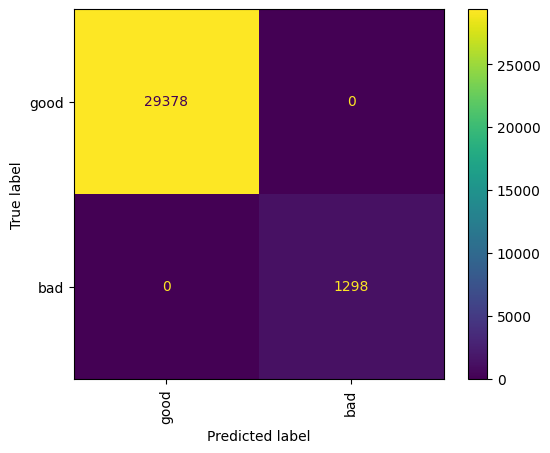

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29378
           1       1.00      1.00      1.00      1298

    accuracy                           1.00     30676
   macro avg       1.00      1.00      1.00     30676
weighted avg       1.00      1.00      1.00     30676



,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
### Initialize the model
model3 = DecisionTreeClassifier(random_state=42)

# train the model
model3.fit(X_train,y_train)

# check performance on train data
dt_train_perf = model_performance_classification_sklearn(
    model3, X_train, y_train, classes=["good","bad"]
)
dt_train_perf

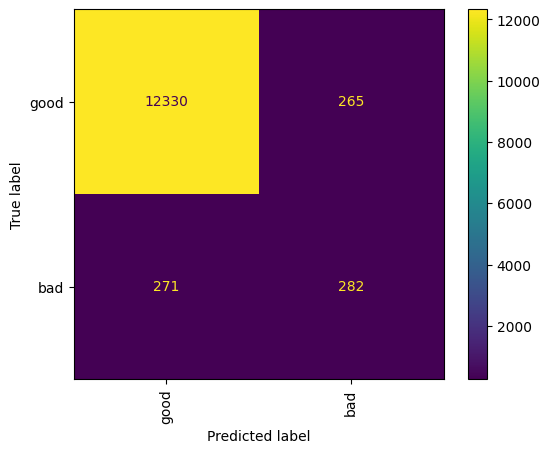

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12595
           1       0.52      0.51      0.51       553

    accuracy                           0.96     13148
   macro avg       0.75      0.74      0.75     13148
weighted avg       0.96      0.96      0.96     13148



,Accuracy,Recall,Precision,F1
0,0.959233,0.744453,0.747017,0.745727


In [ ]:
# check performance on test data
dt_test_perf = model_performance_classification_sklearn(
    model3, X_test, y_test, classes=["good","bad"]
)
dt_test_perf

### Random Forest Model

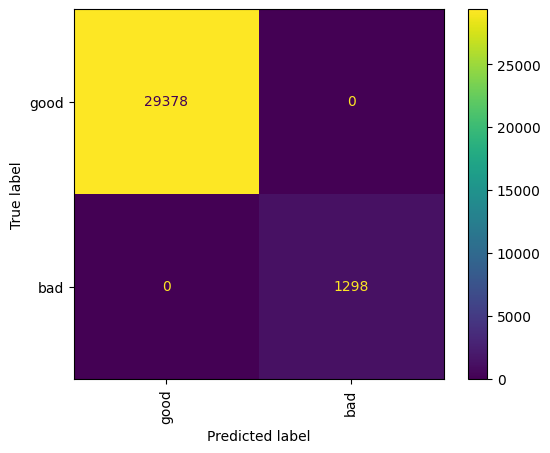

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29378
           1       1.00      1.00      1.00      1298

    accuracy                           1.00     30676
   macro avg       1.00      1.00      1.00     30676
weighted avg       1.00      1.00      1.00     30676



,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [ ]:
### Initialize the model
model4 = RandomForestClassifier(random_state=42)

# train the model
model4.fit(X_train,y_train)

# check performance on train data
rf_train_perf = model_performance_classification_sklearn(
    model4, X_train, y_train,classes=["good","bad"]
)
rf_train_perf

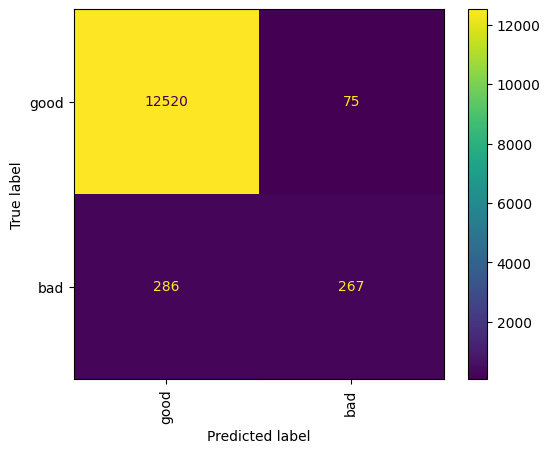

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12595
           1       0.78      0.48      0.60       553

    accuracy                           0.97     13148
   macro avg       0.88      0.74      0.79     13148
weighted avg       0.97      0.97      0.97     13148



,Accuracy,Recall,Precision,F1
0,0.972543,0.738433,0.879184,0.791218


In [ ]:
# check performance on test data
rf_test_perf = model_performance_classification_sklearn(
    model4, X_test, y_test,classes=["good","bad"]
)
rf_test_perf

### Feature importance

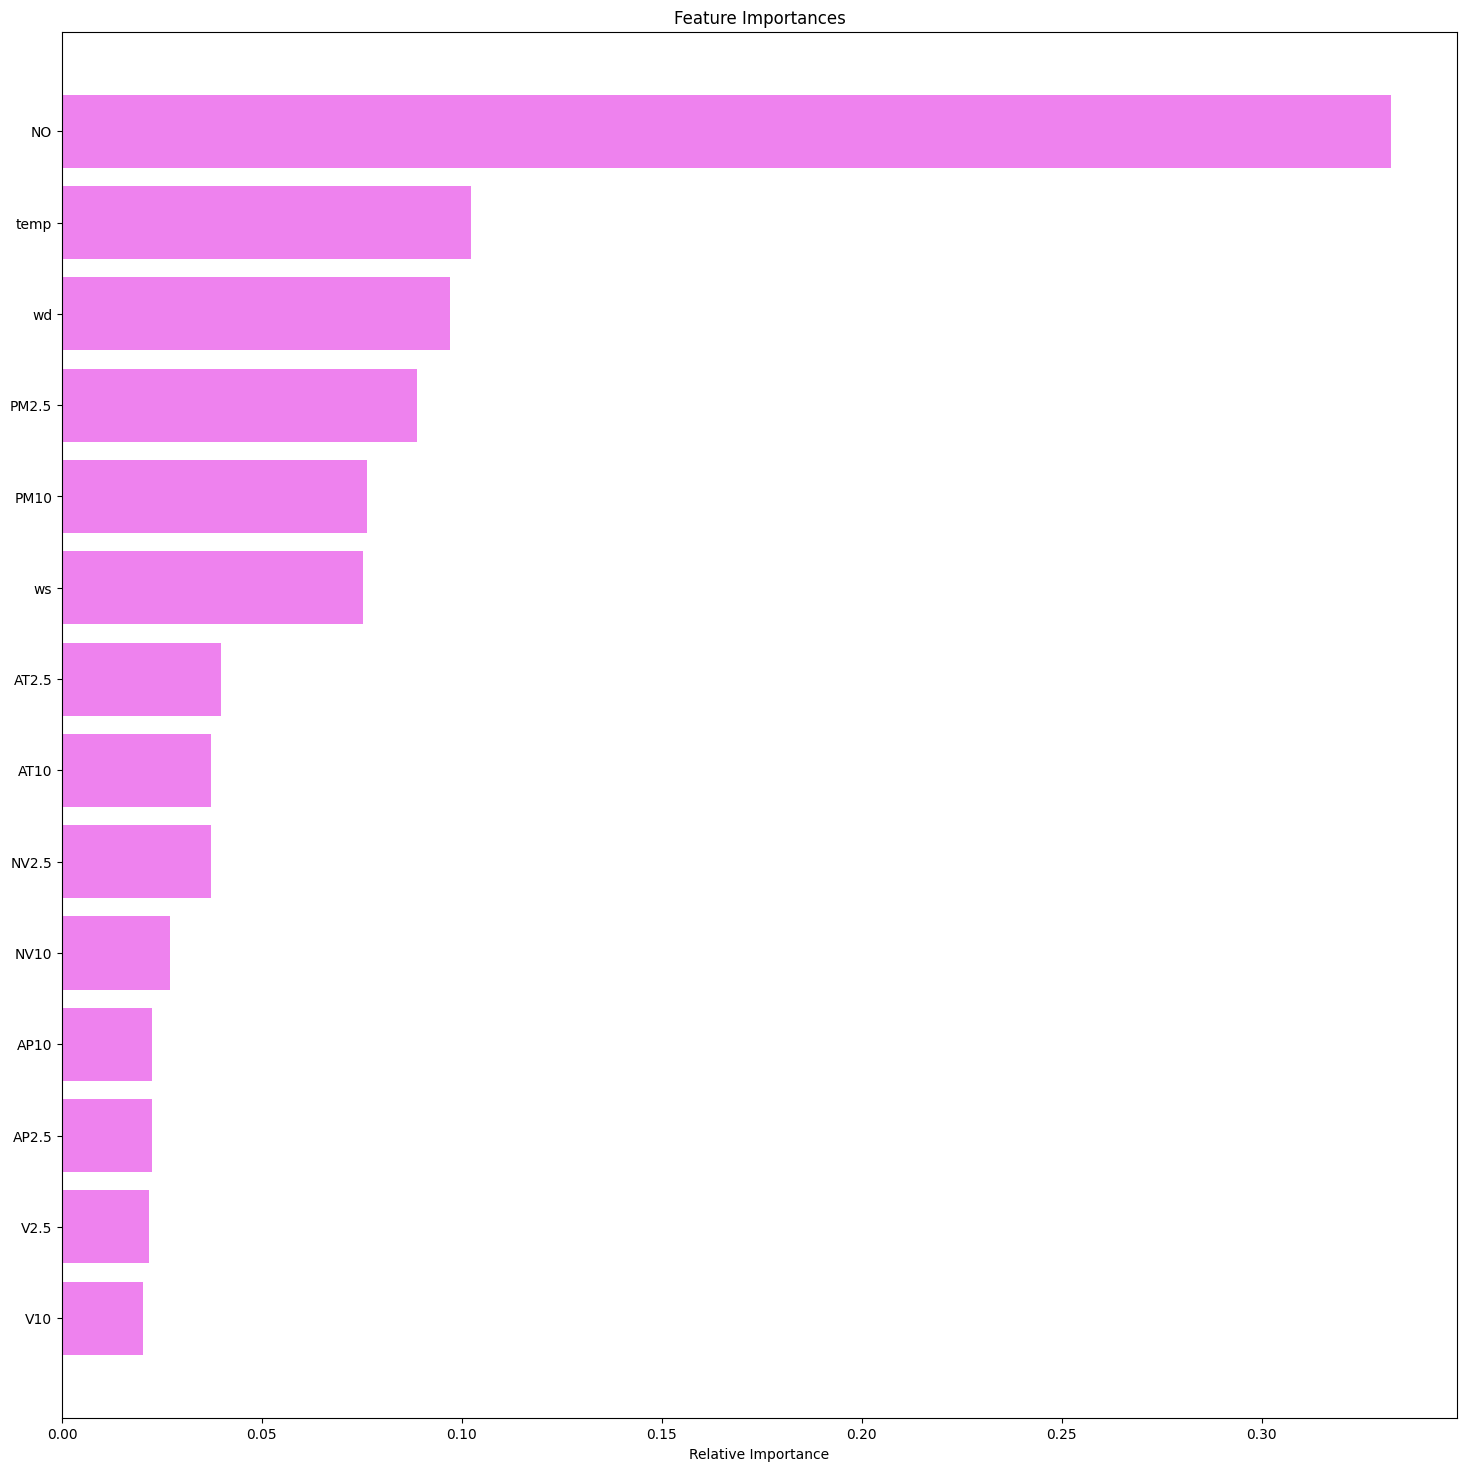

In [ ]:
feature_names = X.columns
importances = (
    model4.feature_importances_
)  ## Complete the code to check the feature importance of the best model
indices = np.argsort(importances)

plt.figure(figsize=(18, 18))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## MODEL COMPARISION

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [knn_train_perf.T, adb_train_perf.T, dt_train_perf.T ,rf_train_perf.T], axis=1,
)
models_train_comp_df.columns = [
    "KNN ",
    "Adaboost ",
    "Decision Tree ",
    "Random Forest ",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,KNN,Adaboost,Decision Tree,Random Forest
Accuracy,0.979169,0.968966,1.0,1.0
Recall,0.808344,0.763253,1.0,1.0
Precision,0.914253,0.822114,1.0,1.0
F1,0.852783,0.789379,1.0,1.0


In [ ]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [knn_test_perf.T,adb_test_perf.T,dt_test_perf.T, rf_test_perf.T], axis=1,
)
models_test_comp_df.columns = [
    "KNN ",
    "Adaboost",
    "Decision Tree",
    "Random Forest",
]
print("testing performance comparison:")
models_test_comp_df

testing performance comparison:


,KNN,Adaboost,Decision Tree,Random Forest
Accuracy,0.970946,0.966307,0.959233,0.972543
Recall,0.728955,0.733449,0.744453,0.738433
Precision,0.863078,0.804163,0.747017,0.879184
F1,0.779311,0.763607,0.745727,0.791218


# **Hybrid approach**

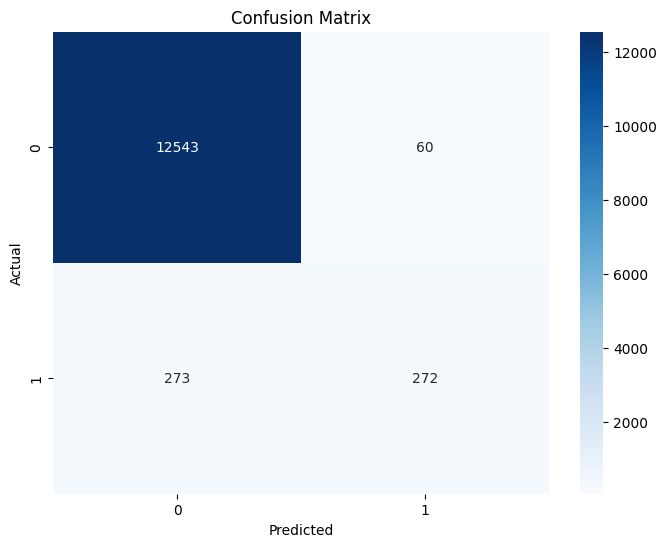

Accuracy: 0.97
F1 Score: 0.97


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Define individual classifiers
svc = SVC(probability=True)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)

# Create a VotingClassifier with 'soft' voting
voting_classifier = VotingClassifier(
    estimators=[
        ('svc', svc),
        ('rf', rf),
        ('ada', ada),
        ('lr', lr),
        ('knn', knn),
        ('dt', dt)
    ],
    voting='soft'  # You can use 'hard' or 'soft' voting
)

# Fit the voting classifier on the training data
voting_classifier.fit(X_train, y_train)

# Predictions
y_pred = voting_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display accuracy and F1 score
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')


In [35]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Display precision and recall
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


Precision: 0.97
Recall: 0.97
